In [3]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from typing import Any
from tqdm.notebook import tqdm
import concurrent.futures
import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.constants as cte
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skipper_image_analysis.utils import (
    correct_overscan, get_rowcol_ovserscan, prepare_frame, filtro_dipolos,
    frame_coords_to_ccd_coords, ccd_coords_to_frame_coords, gaussiana
)

def intensidad_func(tph, tau, PcD):
    npump = 3000
    n = 8
    return npump*PcD*(np.exp(-tph/tau) - np.exp(-n*tph/tau))


def tau_func(T, e_kb, tau_0):
    return tau_0 / (T**2) * np.exp(e_kb/T)


# def d_tau_func_dT(T, e_kb, tau_0):
#     return -tau_0* (2 * T + e_kb) * np.exp(e_kb / T) / T**4


def seccion_eficaz(tau_0):
    h_planck = cte.h / cte.eV  # eV·s
    m_e = cte.electron_mass / cte.eV * cte.c**2  # eV/c²
    k_boltz = cte.Boltzmann / cte.eV  # eV/K
    m_cond = 0.41 * m_e  # eV/c²
    m_dens = 0.94 * m_e  # eV/c²
    sigma = (
        ((h_planck**3) * m_cond**0.5)  # eV³·s³·sq(eV)/c
        / (2 * tau_0 * (3**0.5) * (k_boltz**2) * (2 * np.pi * m_dens)**(3/2))  # s·T²·eV²·sq(eV³)/c³K²
    )  # s²c²
    return sigma * (cte.c**2) * (100**2)  # cm²


def results_col_parser(list_like_string: str) -> list[Any]:
    list_like_string = "".join(list_like_string.split("\n"))
    return np.array([eval(x.strip()) for x in list_like_string[1:-1].split(" ") if x])


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "large"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    126: [
        "skipper_data/TRAPS/02JUN2024_126K_EXP30s_LED_30s",
    ],
    127: [
        "skipper_data/TRAPS/06MAY2024_127K_LED_30s",
    ],
    130: [
        "skipper_data/TRAPS/01JUN2024_130K_EXP30s_LED_30s",
    ],
    135: [
        "skipper_data/TRAPS/02JUN2024_135K_EXP30s_LED_30s",
    ],
    140: [
        "skipper_data/TRAPS/01JUN2024_140K_EXP30s_LED_30s",
    ],
    145: [
        "skipper_data/TRAPS/02JUN2024_145K_EXP30s_LED_30s",
    ],
    151: [
        "skipper_data/TRAPS/31MAY2024_151K_EXP30s_LED_30s",
    ],
    152: [
        "skipper_data/TRAPS/03JUN2024_152p5K_EXP30s_LED_30s",
    ],
    160: [
        "skipper_data/TRAPS/03JUN2024_160K_EXP30s_LED_30s",
    ],
    166: [
        "skipper_data/TRAPS/03JUN2024_166K_EXP30s_LED_30s",
    ],
    171: [
        "skipper_data/TRAPS/04JUN2024_171K_EXP30s_LED_30s",
    ],
    172: [
        "skipper_data/TRAPS/04JUN2024_172K_EXP30s_LED_30s",
    ],
    180: [
        "skipper_data/TRAPS/19AUG2024_180K_EXP30s_LED_30s",
    ],
    190: [
        "skipper_data/TRAPS/19AUG2024_190K_EXP30s_LED_30s",
    ],
    195: [
        "skipper_data/TRAPS/19AUG2024_195K_EXP30s_LED_30s",
    ]
}
DATA_DIR_COUNT = sum([len(dir_list) for dir_list in CARPETAS_POR_TEMP.values()])
RESULTS_DIR = "skipper_image_analysis/TRAPS_estudio_fondo"
CLOCKS_TO_SEC = 15e6  # Hz
DTPH_VALS = np.array(
    [50, 75, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200, 76800, 102400, 153600, 204800]
)
# Define Bins so that each value is at the center of the bin in a log scale
DTPH_BINS = np.sqrt(DTPH_VALS[1:] * DTPH_VALS[:-1])
DTPH_BINS = np.insert(DTPH_BINS, 0, DTPH_VALS[0]*0.8)
DTPH_BINS = np.append(DTPH_BINS, DTPH_VALS[-1]*1.2)

bounds = np.arange(125-2.5, 195+2.5, 5)  # K
norm = mcolors.BoundaryNorm(bounds, plt.cm.plasma.N, extend="max")
temp_colors = plt.cm.ScalarMappable(
    norm=norm,
    cmap="plasma",
)
dtph_colors = plt.cm.ScalarMappable(
    norm=mcolors.LogNorm(DTPH_VALS[0]/CLOCKS_TO_SEC, DTPH_VALS[-1]/CLOCKS_TO_SEC),
    cmap="viridis"
)

In [2]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold_factor: float = 4, corte_simetria: float = 30
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold_factor {float, optional}`: Factor por el que se multiplica al \
ancho de la distribución de carga en la CCD para calcular el umbral de selección. Es \
decir, un dipolo se considera válido si su autocorrelación es menor que \
`-(threshold_factor * ancho_dist)**2`, donde `ancho_dist` es el ancho de la distribución \
de carga en la CCD. Valor por defecto = 3.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir
                    if (f.rsplit(".")[-1] in valid_formats) and ("dTph" in f)]
    files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
    frames_dict = dict()
    mediana_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos", leave=True):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], mediana_dict[dtph], error_dict[dtph] = prepare_frame(
            test_image, frame_idx, remove_row_median=True,
        )  # e⁻
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold_factor, corte_simetria
        )
    return coords_dict, frames_dict, vals_dict, mediana_dict, error_dict, mascara_dipolos

In [3]:
def identificacion_e_intensidad(
    coords_dict: dict,
    frames_dict: dict,
    vals_dict: dict,
    mediana_dict: dict,
    errors_dict: dict,
) -> tuple[list, list, list, list]:
    """Identifica trampas en todos los dtph y busca la intensidad de cada trampa en \
todos los dtph.
    """
    trampas_halladas = []
    intensidad_por_trampa = []
    error_por_trampa = []
    dtph_vals = list(coords_dict.keys())
    dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
    error_vals = [  # e⁻
        errors_dict[dtph]/np.sqrt(2) for dtph in dtph_vals
    ]  # Error propagado al calcular la intensidad como la mitad de la diferencia
    for dtph in tqdm(
        dtph_vals[::-1],
        desc="Recorriendo dTph",
        total=len(dtph_vals),
        leave=False,
    ):
        coordenadas_trampas = coords_dict[dtph]
        valores_trampas = vals_dict[dtph]
        # mediana_trampas = mediana_dict[dtph]
        for coords, valor in zip(
            coordenadas_trampas, valores_trampas
        ):
            if coords in trampas_halladas:
                # Si ya se encontró la trampa, no hace falta volver a propagar.
                propagar_a_todos = False
            # elif valor > (mediana_trampas / 3):
            #     # Si la intensidad del dipolo es mayor a un tercio de la carga media
            #     # de la CCD, entonces seguro es una trampa y hay que propagarla.
            #     propagar_a_todos = True
            elif sum([coords in coords_dict[t_ph] for t_ph in dtph_vals]) >= 3:
                # Si la trampa está en más de dos dtph, entonces seguro es una trampa
                # y hay que propagarla.
                propagar_a_todos = True
            else:
                # Si no se cumple ninguna de las condiciones anteriores, no se
                # propaga la trampa.
                propagar_a_todos = False
            if propagar_a_todos:
                # Propagar la trampa a todos los dtph y guardamos las curvas de I(t_ph).
                intensidades_trampa = []
                errores_trampa = []
                for dtph_frames in dtph_vals:
                    frame = frames_dict[dtph_frames]
                    intensidad_trampa = np.abs(frame[coords[0]] - frame[coords[1]]) / 2
                    # e⁻
                    # min_row = min(coords[0][0], coords[1][0])
                    # varianza_poisson = np.median(frame[min_row-1:min_row+2, :])
                    # La varianza va cómo el valor medio observado para un píxel, con el
                    # valor medio estimado a partir de la distribución de las filas
                    # error_trampa = np.sqrt(
                    #     errors_dict[dtph_frames]**2  # Error lectura
                    #     # + varianza_poisson  # Error iteración (para cada dtph)
                    # ) / np.sqrt(2)  # Propagado del cálculo de la intensidad
                    intensidades_trampa.append(intensidad_trampa)
                    # errores_trampa.append(error_trampa)

                intensidad_por_trampa.append(intensidades_trampa)
                # error_por_trampa.append(errores_trampa)
                error_por_trampa.append(error_vals)
                trampas_halladas.append(coords)
    return trampas_halladas, intensidad_por_trampa, error_por_trampa, dtph_vals

## Análisis de la Intensidad de las Trampas

In [6]:
def process_temperature(temperatura, carpetas):
    trampas = []  # trampas[dir_idx][coord_idx]
    intensidad = []  # intensidad[dir_idx][coord_idx][dtph_idx]
    dtph = []  # dtph[dir_idx][dtph_idx]
    error = []  # error[dir_idx][coord_idx][dtph_idx]
    for dir_idx in range(len(carpetas)):
        print(f"Procesando Carpeta {carpetas[dir_idx]}...")
        for frame_idx in [0, 1]:
            print(f"Recorriendo Frame {frame_idx}...")
            coords_dict, frames_dict, vals_dict, mediana_dict, errors_dict, _ = carga_archivos(
                temperatura, dir_idx, frame_idx, threshold_factor=3, corte_simetria=30,
            )
            trampas_halladas, intensidad_por_trampa, error_por_trampa, dtph_vals = identificacion_e_intensidad(
                coords_dict, frames_dict, vals_dict, mediana_dict, errors_dict
            )
            # Transformamos las coordenadas de los dipolos al sistema de coords de la CCD
            CCDNROW = 1658
            CCDNCOL = 572
            trampas_halladas = [
                (
                    frame_coords_to_ccd_coords(coords[0], frame_idx, CCDNROW, CCDNCOL),
                    frame_coords_to_ccd_coords(coords[1], frame_idx, CCDNROW, CCDNCOL),
                ) for coords in trampas_halladas
            ]
            trampas.append(trampas_halladas)
            intensidad.append(intensidad_por_trampa)
            error.append(error_por_trampa)
            dtph.append(dtph_vals)
    return trampas, intensidad, error, dtph, temperatura

try:
    trampas_temp = pickle.load(open(f"{RESULTS_DIR}/trampas.pkl", "rb"))
    intensidades_temp = pickle.load(open(f"{RESULTS_DIR}/intensidades.pkl", "rb"))
    errores_temp = pickle.load(open(f"{RESULTS_DIR}/errores.pkl", "rb"))
    dtph_temp = pickle.load(open(f"{RESULTS_DIR}/dtph.pkl", "rb"))
    print(f"Resultados intermedios cargados desde Pickles en {RESULTS_DIR}")
except FileNotFoundError:
    trampas_temp: dict[int, list[list[tuple[tuple[int]]]]] = dict()
    intensidades_temp: dict[int, list[list[list[float]]]] = dict()
    errores_temp: dict[int, list[list[list[float]]]] = dict()
    dtph_temp: dict[int, list[list[int]]] = dict()
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for temperatura, carpetas in CARPETAS_POR_TEMP.items():
            futures.append(executor.submit(process_temperature, temperatura, carpetas))
        
        for future in concurrent.futures.as_completed(futures):
            trampas, intensidad, error, dtph, temperatura = future.result()
            trampas_temp[temperatura] = trampas
            intensidades_temp[temperatura] = intensidad
            errores_temp[temperatura] = error
            dtph_temp[temperatura] = dtph
    # Save to Pickle
    if not os.path.exists(RESULTS_DIR):
        os.mkdir(RESULTS_DIR)
    with open(f"{RESULTS_DIR}/trampas.pkl", "wb") as file:
        pickle.dump(trampas_temp, file)
    with open(f"{RESULTS_DIR}/intensidades.pkl", "wb") as file:
        pickle.dump(intensidades_temp, file)
    with open(f"{RESULTS_DIR}/errores.pkl", "wb") as file:
        pickle.dump(errores_temp, file)
    with open(f"{RESULTS_DIR}/dtph.pkl", "wb") as file:
        pickle.dump(dtph_temp, file)

Resultados intermedios cargados desde Pickles en skipper_image_analysis/TRAPS_estudio_fondo


In [7]:
trampas_unicas_por_temp = dict()
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    trampas_unicas = []
    for dir_idx, _ in enumerate(carpetas):
        for frame_idx in [0, 1]:
            trampas_unicas.extend(trampas_temp[temperatura][2*dir_idx + frame_idx])
    trampas_unicas = set(trampas_unicas)
    trampas_unicas_por_temp[temperatura] = trampas_unicas

lista_todas_trampas = [list(trampas_temp) for trampas_temp in trampas_unicas_por_temp.values()]
lista_todas_trampas = sum(lista_todas_trampas, [])

In [8]:
# Calculo Máscaras por Saturación
mascara_saturacion_temp: dict[int, list[list[list[bool]]]] = dict()
# [temperaturaa][dir_idx][coord_idx][dtph_idx]
for temperatura, carpetas in tqdm(CARPETAS_POR_TEMP.items(), desc="Temperaturas"):
    mascaras_temperatura = []
    for dir_idx, data_dir in enumerate(carpetas):
        
        files_in_dir = [
            file for file in os.listdir(data_dir)
            if (file.endswith(".fits") and ("dTph" in file))
        ]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx])
        umbrales_dtph: dict[int, list[ArrayLike]] = dict()  # [dtph][frame_idx][row_idx]
        for dtph, file in zip(dtph_vals, files_in_dir):
            test_image = fits.open(f'{data_dir}/{file}')
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            umbrales_dtph[dtph] = []  # para guardar los valores umbrales por fila por dtph
            for frame_idx in [0, 1]:
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                area_activa = test_frame[
                    1:-row_overscan_len, PRESCAN_PIX+2:-col_overscan_len
                ]
                filtro_inf = area_activa > np.quantile(area_activa, 0.005)
                filtro_sup = area_activa < np.quantile(area_activa, 0.99)
                area_activa_filtrada = np.where(
                    filtro_inf & filtro_sup,
                    area_activa,
                    np.nan
                )
                umbrales_dtph[dtph].append(
                    np.nanmean(area_activa_filtrada, axis=1)
                    - 3*np.nanstd(area_activa_filtrada, axis=1, ddof=1)
                )
        for frame_idx in [0, 1]:
            mascaras_dir = []
            for coord_idx, (coords, intensidades_mask, errores_mask) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                intensidades_mask = np.array(intensidades_mask)
                errores_mask = np.array(errores_mask)
                mascara_trampa = np.zeros_like(intensidades_mask, dtype=bool)
                fila_trampa = coords[1][0]
                for idx, (dtph, intensidad, error) in enumerate(
                    zip(dtph_vals, intensidades_mask, errores_mask)
                ):
                    umbral = umbrales_dtph[dtph][frame_idx][fila_trampa]
                    mascara_trampa[idx] = (intensidad + error) >= umbral
                    # Si la intensidad + error es mayor al umbral, entonces la trampa está saturada
                mascaras_dir.append(mascara_trampa)
            mascaras_temperatura.append(mascaras_dir)
    mascara_saturacion_temp[temperatura] = mascaras_temperatura

Temperaturas:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_48686/1320867751.py:33: RuntimeWarning: Mean of empty slice
  np.nanmean(area_activa_filtrada, axis=1)
/home/agustin/Documents/FCEN/LAMBDA/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
total_puntos = 0
puntos_saturan = 0
curvas_saturan = 0
for temp, mascaras in mascara_saturacion_temp.items():
    for dir_idx, mascara_dir in enumerate(mascaras):
        for mascara_coord in mascara_dir:
            # print(mascara_coord)
            total_puntos += mascara_coord.size
            puntos_saturan += np.sum(mascara_coord)
            curvas_saturan += (np.sum(~mascara_coord) < 6)
print(f"Se saturan {puntos_saturan} dipolos de {total_puntos} identificados ({puntos_saturan/total_puntos*100:.2f}%)")
print(f"Se saturan {curvas_saturan} curvas de {len(lista_todas_trampas)} identificadas ({curvas_saturan/len(lista_todas_trampas)*100:.2f}%)")

Se saturan 46 dipolos de 199682 identificados (0.02%)
Se saturan 0 curvas de 8793 identificadas (0.00%)


In [10]:
# Ajustamos los datos (enmascarando por saturación) a las curvas I(t_ph)
systematic_error = 50  # e⁻

trampas_ajustadas = []
tau_ajustados = []
err_tau_ajustados = []
pc_ajustados = []
temps_datos_ajustados = []
intensidades_ajustadas = []
error_intensidades_ajustadas = []
tph_ajustados = []
mascaras_ajustadas = []
pvalues_ajustados = []

for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for dir_idx in range(len(carpetas)):
        for frame_idx in [0, 1]:
            dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx + frame_idx])
            for coord_idx, (
                coords,
                intensidades,
                errores,
                mascara_saturacion,
            ) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                    mascara_saturacion_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                if np.sum(~mascara_saturacion) < 6:
                    # Si hay menos de 5 puntos para ajustar, no se hace el ajuste
                    continue
                errores = [np.sqrt(e**2 + systematic_error**2) for e in errores]
                dtph_mask = dtph_vals[~mascara_saturacion]
                intensidades_mask = np.array(intensidades)[~mascara_saturacion]
                errores_mask = np.array(errores)[~mascara_saturacion]
                
                idx_pico = np.argmax(intensidades_mask)
                if (dtph_mask[idx_pico] in [dtph_vals[0], dtph_vals[-1]]):
                    continue
                dtph_maxval = dtph_mask[idx_pico]  # s
                intensidad_maxval = np.max(intensidades)  # e⁻
                # Ajustes al Modelo
                tau_estimado = dtph_maxval / 0.296  # CLOCKS
                pc_estimado = intensidad_maxval * 8 / 3_000 / 5.2
                try:
                    popt, pcov = curve_fit(
                        intensidad_func,
                        dtph_mask,
                        intensidades_mask,
                        sigma=errores_mask,
                        absolute_sigma=True,
                        p0=[tau_estimado, pc_estimado],
                        bounds=(
                            [DTPH_VALS[0] / 0.296, 0],
                            [DTPH_VALS[-1] / 0.296, np.inf],
                        ),
                    )
                except RuntimeError:
                    continue
                perr = np.sqrt(np.diag(pcov))
                # Chi² del fit
                grados_libertad = len(dtph_mask) - len(popt)
                chi2_obs = np.sum(
                    (
                        (intensidades_mask - intensidad_func(dtph_mask, *popt))
                        / errores_mask
                    )**2
                )
                p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function
                # Guardamos todos los resultados
                trampas_ajustadas.append(coords[-1])
                tau_ajustados.append(popt[0]/CLOCKS_TO_SEC)  # s
                err_tau_ajustados.append(perr[0]/CLOCKS_TO_SEC)  # s
                pc_ajustados.append(popt[1])  # e⁻
                temps_datos_ajustados.append(temperatura)  # K
                intensidades_ajustadas.append(intensidades)  # e⁻
                error_intensidades_ajustadas.append(errores)  # e⁻
                tph_ajustados.append(dtph_vals/CLOCKS_TO_SEC)  # s
                pvalues_ajustados.append(p_value)
                mascaras_ajustadas.append(mascara_saturacion)

resultados_ajustes = pd.DataFrame(
    data={
        "Trampa": trampas_ajustadas,
        "Tau": tau_ajustados,
        "Error Tau": err_tau_ajustados,
        "Pc": pc_ajustados,
        "Temperatura": temps_datos_ajustados,
        "Intensidad": intensidades_ajustadas,
        "Error Intensidad": error_intensidades_ajustadas,
        "tph": tph_ajustados,
        "Máscara": mascaras_ajustadas,
        "p-valor": pvalues_ajustados,
    }
)

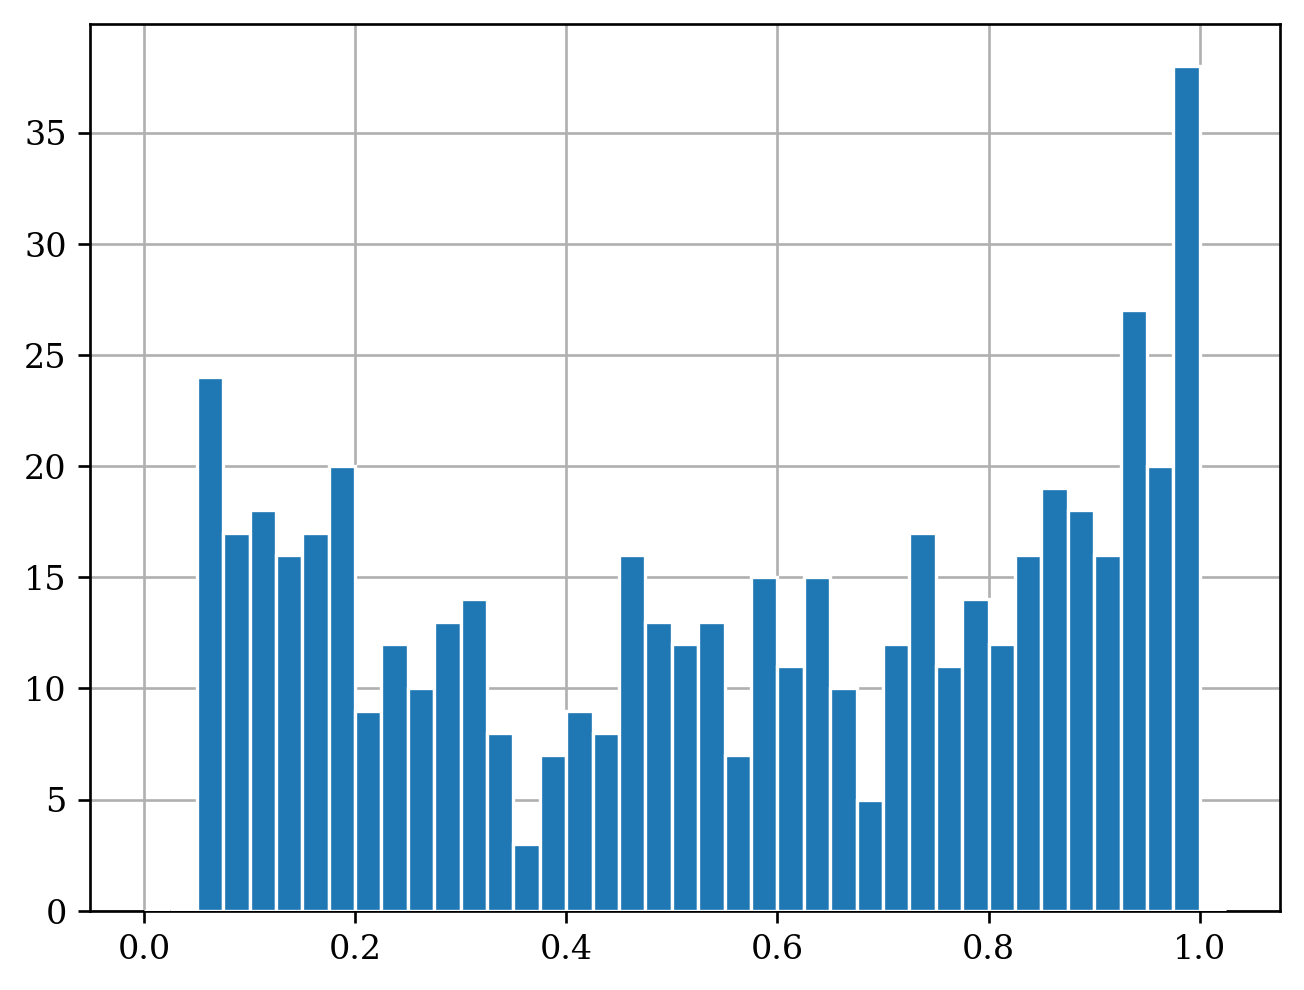

In [11]:
# Otros defectos... No filtrar todos manualmente pero los anoto
# ajustes_malos = [(749, 177), (576, 446), (165, 433), (279, 394), (734, 100), (207, 84), (80, 59), (207, 84), (9, 300), (767, 556), (295, 393)]
doble_respuesta = [(142, 481), (443, 387), (154, 552), (121, 483), (54, 370)]
# ver = [(674, 497)]

filtro_p_valor = resultados_ajustes["p-valor"] > 0.05
filtro_dobles = ~resultados_ajustes["Trampa"].isin(doble_respuesta)
resultados_filtrados = resultados_ajustes[filtro_p_valor & filtro_dobles]

resultados_filtrados["p-valor"].hist(bins=np.arange(0, 1.05, 0.025), edgecolor="w", zorder=10)
# plt.yscale("log")
plt.show()

In [12]:
# Guardamos los resultados
resultados_ajustes.to_csv(f"{RESULTS_DIR}/resultados_ajustes_raw.csv", index=False)
resultados_filtrados.to_csv(f"{RESULTS_DIR}/resultados_ajustes_filtrados.csv", index=False)

# Estudio de Homogeneidad de la Distribución Espacial de las Trampas

In [2]:
# En vez de correr el código hasta acá (que puede ser lento), cargamos los resultados.
resultados_filtrados = pd.read_csv(
    f"{RESULTS_DIR}/resultados_ajustes_filtrados.csv",
    index_col=False,
    converters={
        "Trampa": eval,
        "Intensidad": eval,
        "Error Intensidad": eval,
        "tph": results_col_parser,
        "Máscara": results_col_parser,
    }
)

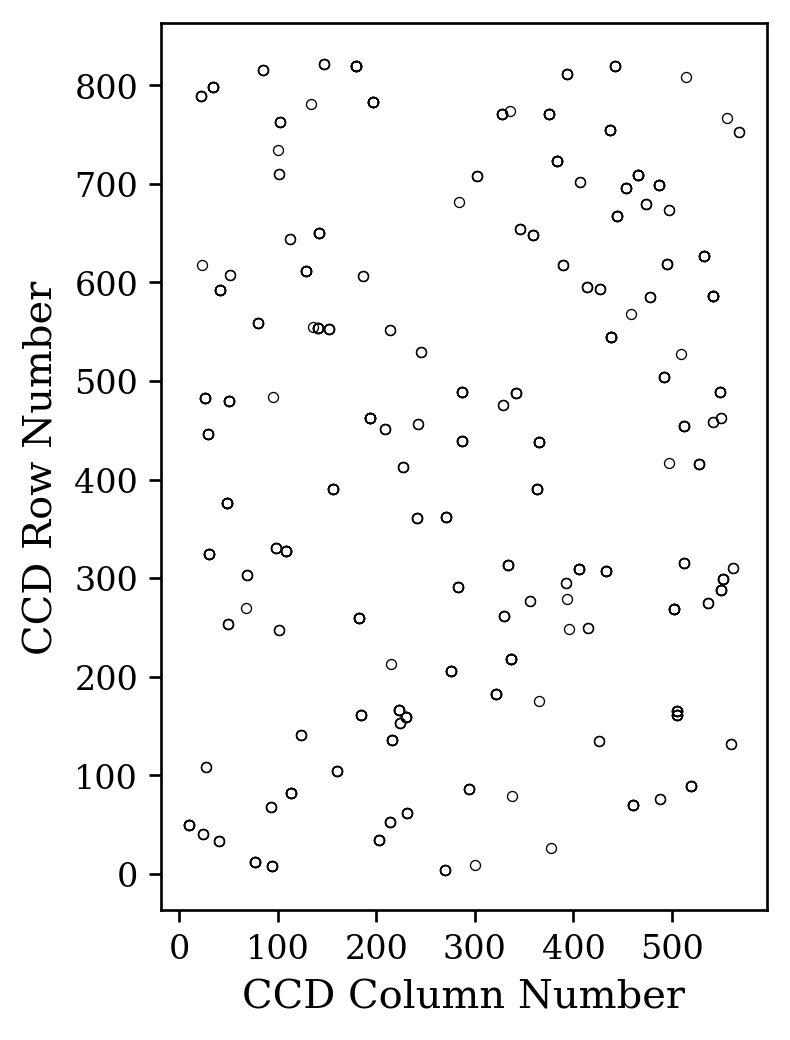

In [10]:
rows = []
cols = []
for coords in resultados_filtrados["Trampa"]:
    rows.append(coords[0])
    cols.append(coords[1])

plt.plot(cols, rows, ".", mec="k", mew=0.4, mfc="none")
# plt.title("Coordenadas de las trampas en la CCD")
plt.gca().set_aspect("equal")
plt.xticks(np.arange(0, 572, 100))
plt.xlabel("CCD Column Number")
plt.ylabel("CCD Row Number")
plt.show()

In [25]:
# Distancias Observadas entre Trampas
dists_ccd = []
coords_ccd = np.stack(resultados_filtrados["Trampa"].apply(np.array).to_list())
coords_ccd = np.unique(coords_ccd, axis=0)
for i, coords_i in enumerate(coords_ccd):
    dists_ccd += np.linalg.norm(coords_i - coords_ccd[i+1:], axis=1).tolist()

In [26]:
# Montecarlo
rng = np.random.default_rng(seed=42)
all_coords = [
    [(row, col) for col in range(336 * 2)]
    for row in range(879)
]
all_coords = np.concatenate(all_coords, axis=0)
resultados_montecarlo = []
for _ in tqdm(range(10_000), desc="Simulando Montecarlo"):
    dists_uniform = []
    coords_uniform = all_coords[
        rng.choice(
            np.arange(all_coords.shape[0]),
            size=coords_ccd.shape[0],
            replace=False,
        )
    ]
    for i, coords_i in enumerate(coords_uniform):
        dists_uniform += np.linalg.norm(coords_i - coords_uniform[i+1:], axis=1).tolist()
    resultados_montecarlo.append(dists_uniform)

Simulando Montecarlo:   0%|          | 0/10000 [00:00<?, ?it/s]

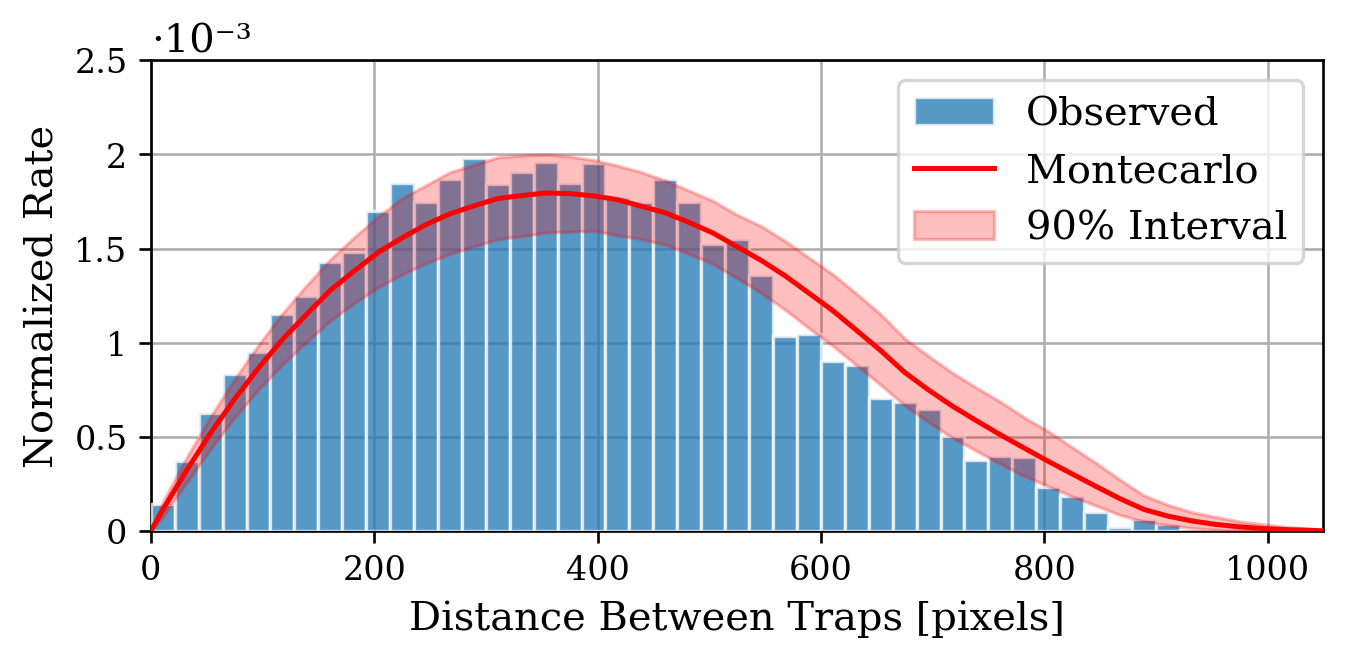

In [27]:
edges = np.linspace(0, 1_050, 50)
montecarlo_hists = np.zeros((len(resultados_montecarlo), len(edges) - 1))
for i, dists_uniform in enumerate(resultados_montecarlo):
    counts, _ = np.histogram(dists_uniform, bins=edges, density=True)
    montecarlo_hists[i] = counts

fig, axs = plt.subplots(1, 1, figsize=(8/1.4, 4/1.4), tight_layout=True)
plt.hist(
    dists_ccd,
    bins=edges,
    edgecolor="w",
    density=True,
    alpha=0.75,
    label="Observed",
    zorder=5,
)
plt.plot(
    np.concatenate([[0], edges[:-1] + np.diff(edges).mean()/2, [1050]]),
    np.concatenate([[0], montecarlo_hists.mean(axis=0), [0]]),
    c="r", ls="-", label="Montecarlo", zorder=6,
)
plt.fill_between(
    x=np.concatenate([[0], edges[:-1] + np.diff(edges).mean()/2, [1050]]),
    y1=np.concatenate([[0], np.quantile(montecarlo_hists, 0.05, axis=0), [0]]),
    y2=np.concatenate([[0], np.quantile(montecarlo_hists, 0.95, axis=0), [0]]),
    # step="mid",
    color="r", alpha=0.25, zorder=5.5,
    label="90% Interval"
)
plt.grid()
plt.legend()
plt.xlim(left=0, right=1050)
plt.xlabel("Distance Between Traps [pixels]")
plt.ylim(bottom=0)
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f"{tick*1e3:.3g}" for tick in plt.gca().get_yticks()], )
plt.title("·10⁻³", loc="left", pad=-10)

plt.ylabel("Normalized Rate")
plt.savefig("plots_paper/spatial_dist.pdf", dpi=600)
plt.show()

# Estudio Tau

In [4]:
# En vez de correr el código hasta acá (que puede ser lento), cargamos los resultados.
resultados_ajustes = pd.read_csv(
    f"{RESULTS_DIR}/resultados_ajustes_raw.csv",
    index_col=False,
    converters={
        "Trampa": eval,
        "Intensidad": eval,
        "Error Intensidad": eval,
        "tph": results_col_parser,
        "Máscara": results_col_parser,
    }
)
resultados_filtrados = pd.read_csv(
    f"{RESULTS_DIR}/resultados_ajustes_filtrados.csv",
    index_col=False,
    converters={
        "Trampa": eval,
        "Intensidad": eval,
        "Error Intensidad": eval,
        "tph": results_col_parser,
        "Máscara": results_col_parser,
    }
)

Trampa de ejemplo: (783, 197)
Trampa de ejemplo: (269, 502)


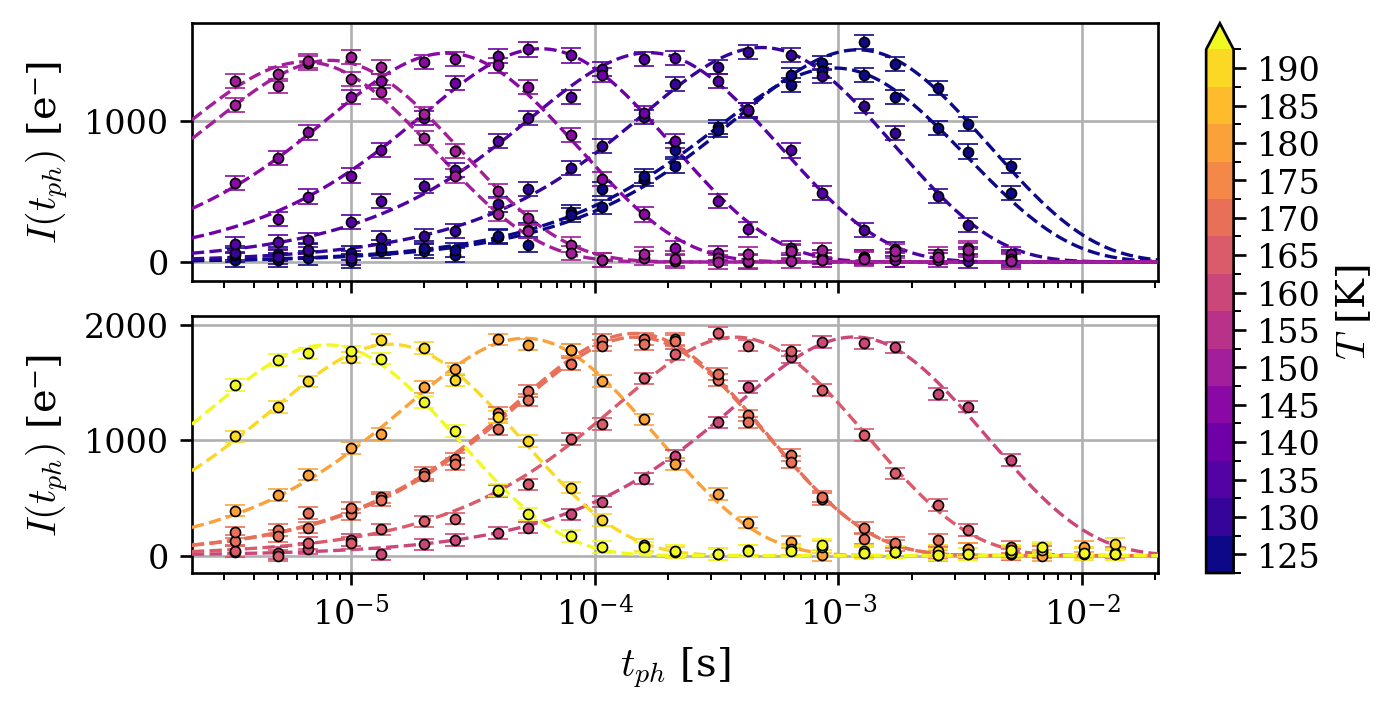

In [5]:
# Graficamos una trampa de ejemplo para varias temperaturas
# trampa_ejemplo = (783, 197)
trampas_unicas, counts = np.unique(resultados_filtrados["Trampa"], return_counts=True)
trampas_varias = trampas_unicas[counts >= 3]
# print(trampas_varias)
# print(len(trampas_varias))
fig, axs = plt.subplots(
    2, 1, sharex=True, sharey=False, layout="constrained", figsize=(8/1.4, 4/1.4)
)
# axs[0].set_title("a) Curvas 'buenas'", loc="left")
# axs[1].set_title("b) Curvas 'malas'", loc="left")
tph_dense = np.geomspace(DTPH_VALS[0] / 1.5, DTPH_VALS[-1] * 1.5, 1000) / CLOCKS_TO_SEC
# for trampa_idx, ax in zip([0, 1], axs):
for trampa_ejemplo, ax in zip(
    [(783, 197), (269, 502)],  # Single Response
    # [(443, 387), (121, 483), (54, 370)],
    axs,
):
    # trampa_ejemplo = trampas_varias[trampa_idx]
    print(f"Trampa de ejemplo: {trampa_ejemplo}")
    filtro_trampa = resultados_ajustes["Trampa"] == trampa_ejemplo

    # text_kwargs_by_temp = {
    #     165: {"va": "bottom", "ha": "center"},
    #     160: {"va": "bottom", "ha": "center"},
    #     150: {"va": "bottom", "ha": "right"},
    #     140: {"va": "center", "ha": "right"},
    #     145: {"va": "bottom", "ha": "right"},
    #     135: {"va": "bottom", "ha": "center"},
    # }
    # text_pad_by_temp = {
    #     165: (0, 100),
    #     160: (0, 50),
    #     150: (0, 50),
    #     140: (-3e-4, 0),
    #     145: (0, 50),
    #     135: (0, 50),
    # }
    for temp, tph_vals, intensidades, errores, mascara_saturacion, tau, pc in zip(
        resultados_ajustes.loc[filtro_trampa, "Temperatura"],
        resultados_ajustes.loc[filtro_trampa, "tph"],
        resultados_ajustes.loc[filtro_trampa, "Intensidad"],
        resultados_ajustes.loc[filtro_trampa, "Error Intensidad"],
        resultados_ajustes.loc[filtro_trampa, "Máscara"],
        resultados_ajustes.loc[filtro_trampa, "Tau"],
        resultados_ajustes.loc[filtro_trampa, "Pc"],
    ):
        tph_vals = np.array(tph_vals)
        intensidades = np.array(intensidades)
        errores = np.array(errores)
        ax.plot(
            tph_vals[mascara_saturacion],
            intensidades[mascara_saturacion],
            "v",
            c="none",
            mec=temp_colors.to_rgba(temp),
            mew=0.5,
            ms=5,
            zorder=10,
            label="Valores Saturados" if temp == 135 else None,
        )
        ax.errorbar(
            tph_vals[~mascara_saturacion],
            intensidades[~mascara_saturacion],
            yerr=errores[~mascara_saturacion],
            fmt=".",
            c=temp_colors.to_rgba(temp),
            mec="k",
            mew=0.5,
            capsize=3,
            elinewidth=0.5,
            zorder=20,
            label="Valores Ajustados" if temp == 135 else None,
        )

        ax.plot(
            tph_dense,
            intensidad_func(tph_dense, tau, pc),
            "--",
            c=temp_colors.to_rgba(temp),
            lw=1,
            zorder=5,
            label="Ajuste" if temp == 135 else None,
        )
        # ax.axhline(
        #     intensidad_func(np.log(8)/(8-1)*tau, tau, pc),
        #     ls="--",
        #     c="r",
        # )
        # ax.text(
        #     tph_vals[max_idx] + text_pad_by_temp[temp][0],
        #     intensidades[max_idx] + text_pad_by_temp[temp][1],
        #     f"{temp} K",
        #     c=temp_colors.to_rgba(temp),
        #     **text_kwargs_by_temp[temp]
        # )
    ax.grid()
    ax.set_xscale("log")

    # plt.yscale("log")
# axs[0].legend()
for ax in axs:
    ax.set_ylabel("$I(t_{ph})$ [e⁻]")
    ax.set_xlim(tph_dense[0], tph_dense[-1])
axs[1].set_xlabel("$t_{ph}$ [s]")
# axs[1].yaxis.tick_right()
# axs[1].yaxis.set_label_position("right")
fig.colorbar(
    temp_colors,
    label="$T$ [K]",
    extend="max",
    ax=axs,
    ticks=temp_colors.norm.boundaries + 2.5,
)
plt.savefig("plots_paper/sample_traps.pdf", dpi=600)
# plt.savefig("plots_paper/dual_response_traps.pdf", dpi=600)
plt.show()

Recorriendo Trampas:   0%|          | 0/138 [00:00<?, ?it/s]

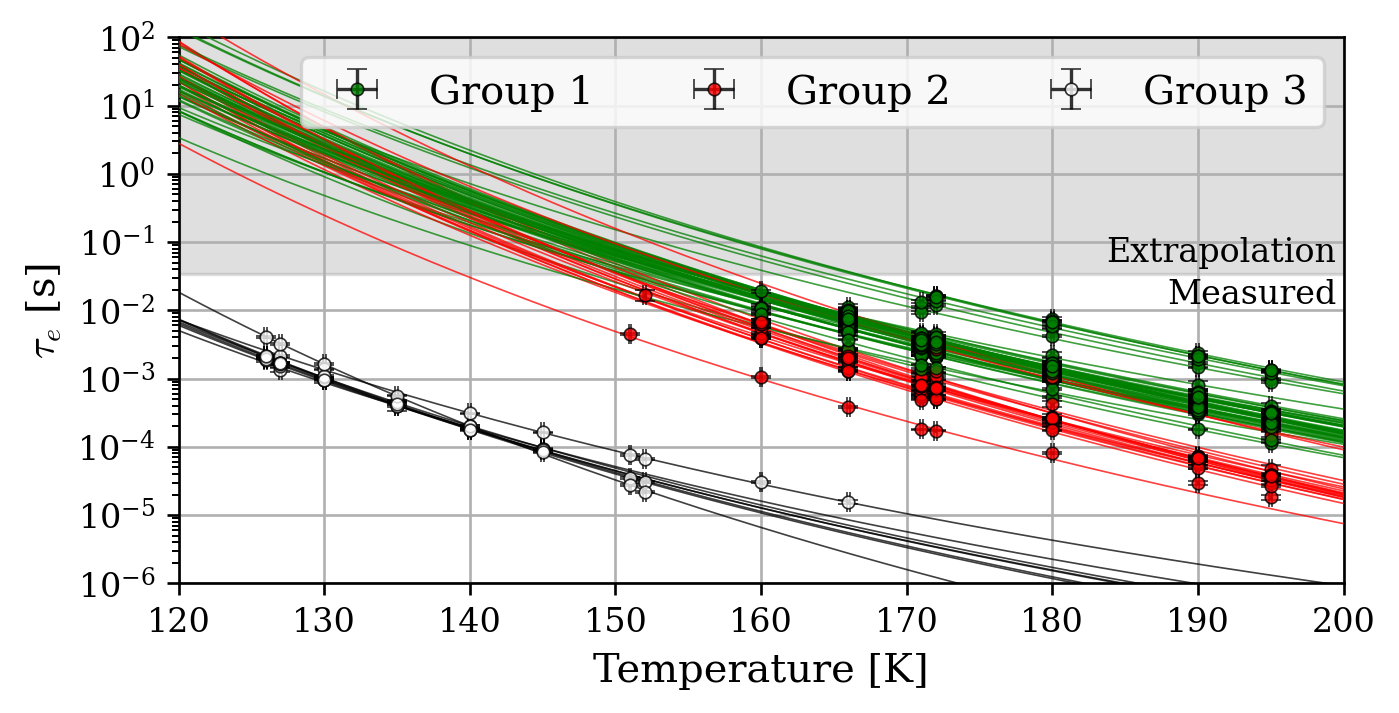

total curvas ajustadas: 77


In [6]:
# Buscamos trampas que aparecen en varias temperaturas y graficamos con el ajuste
fig = plt.figure(figsize=(8/1.4, 4/1.4), constrained_layout=True)
trampas_unicas = set(resultados_filtrados["Trampa"].values)
trampas_en_muchas_temps = []
temps_dense = np.linspace(resultados_filtrados["Temperatura"].min()*0.9, resultados_filtrados["Temperatura"].max()*1.1, 1000)
plot_idx = 0
popt_vals = []
perr_vals = []
p_vals = []
grupo = []
for coord in tqdm(trampas_unicas, desc="Recorriendo Trampas"):
    if sum(resultados_filtrados["Trampa"] == coord) < 4:
        continue
    trampas_en_muchas_temps.append(coord)
    filtro_trampa = (resultados_filtrados["Trampa"] == coord)
    temps = resultados_filtrados.loc[filtro_trampa, "Temperatura"]
    tau_vals = np.array(resultados_filtrados.loc[filtro_trampa, "Tau"])
    tau_errs = np.array(resultados_filtrados.loc[filtro_trampa, "Error Tau"])
    pc_vals = np.array(resultados_filtrados.loc[filtro_trampa, "Pc"])
    try:
        popt, pcov = curve_fit(
            tau_func,
            temps,
            tau_vals,
            sigma=tau_errs,
            absolute_sigma=True,
            bounds=([0, 0], [np.inf, np.inf]),
        )
        perr = np.sqrt(np.diag(pcov))
    except RuntimeError:
        continue
    # Chi2 del fit
    grados_libertad = len(temps) - len(popt)
    chi2_obs = np.sum(
        (
            (tau_vals - tau_func(temps, *popt))
            / tau_errs
        )**2
    )
    p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function

    popt_vals.append(popt)
    perr_vals.append(perr)
    p_vals.append(p_value)
    e_val = popt[0] * cte.Boltzmann / cte.eV
    sigma_val = seccion_eficaz(popt[1])
    if (sigma_val < 5e-15) & (e_val > 0.225):
        color = "g"
        grupo.append(0)
    elif (sigma_val > 5e-15) & (e_val > 0.300) & (sigma_val < 1e-12):
        color = "r"
        grupo.append(1)
    else:
        color = "w"
        grupo.append(2)
    plt.errorbar(
        temps,
        tau_vals,
        yerr=tau_errs,
        xerr=0.1,
        fmt=".", c=color, markersize=7.5, mec="k", mew=0.5,
        ecolor="k", elinewidth=1, capsize=3,
        alpha=0.8,
        zorder=int(10 + plot_idx/100),
        label=(
            {"g": "Group 1", "r": "Group 2", "w": "Group 3"}[color]
            if grupo.count({"g": 0, "r": 1, "w": 2}[color]) == 1
            else None
        )
    )
    plt.plot(
        temps_dense,
        tau_func(temps_dense, *popt),
        "-", c=color if color != "w" else "k",
        lw=0.5, alpha=0.75,
        zorder=int(5 + plot_idx/100),
    )
    plot_idx += 1

plt.fill_between(
    [120, 200],
    [DTPH_VALS[-2] / CLOCKS_TO_SEC / 0.296] * 2,
    [1e2] * 2,
    color="gray",
    alpha=0.25,
)
plt.text(199.5, DTPH_VALS[-2] / CLOCKS_TO_SEC / 0.25, "Extrapolation", va="bottom", ha="right")
plt.text(199.5, DTPH_VALS[-2] / CLOCKS_TO_SEC / 0.35, "Measured", va="top", ha="right")
plt.grid()
plt.legend(loc="upper right", ncols=3)
plt.xlabel("Temperature [K]")
plt.xlim(120, 200)
plt.yscale("log")
plt.ylabel(r"$\tau_e$ [s]")
plt.ylim(1e-6, 1e2)
plt.savefig("plots_paper/ajustes_tau_temp.pdf", dpi=600)

plt.show()

print(f"total curvas ajustadas: {len(popt_vals)}")

In [7]:
traps_params = np.concatenate([np.stack(popt_vals), np.stack(perr_vals)], axis=1)
np.savetxt("skipper_image_analysis/TRAPS_estudio_fondo/traps_params.csv", traps_params, delimiter=",", header="e/kb [K], tau_e [s·K²], error e/kb [K], error tau_e [s·K²]")

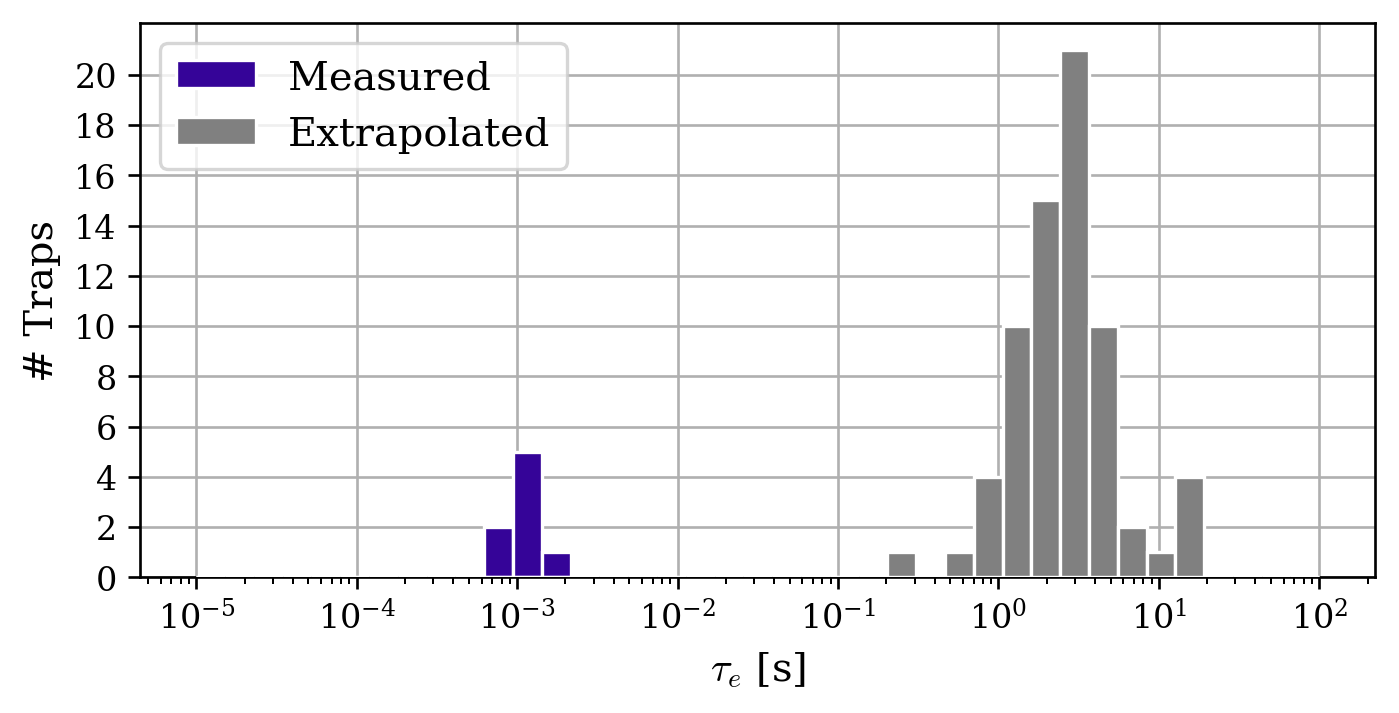

In [8]:
plt.subplots(1, 1, figsize=(8/1.4, 4/1.4), constrained_layout=True)
tau_e_130 = np.array([tau_func(130, *popt) for popt in popt_vals])
tau_domain = np.geomspace(1e-5, 1e2, 40)
plt.hist(tau_e_130[tau_e_130 < DTPH_VALS[-2] / CLOCKS_TO_SEC / 0.296], bins=tau_domain, color=temp_colors.to_rgba(130), ec="w", histtype="bar", label="Measured", zorder=5)
plt.hist(tau_e_130[tau_e_130 > DTPH_VALS[-2] / CLOCKS_TO_SEC / 0.296], bins=tau_domain, color="gray", ec="w", histtype="bar", label="Extrapolated", zorder=5)
plt.grid()
plt.legend(loc="upper left")
plt.xscale("log")
plt.xlabel(r"$\tau_e$ [s]")
plt.ylabel("# Traps")
plt.yticks(np.arange(0, 21, 2))
plt.savefig("plots_paper/hist_tau_130.pdf", dpi=600)
plt.show()

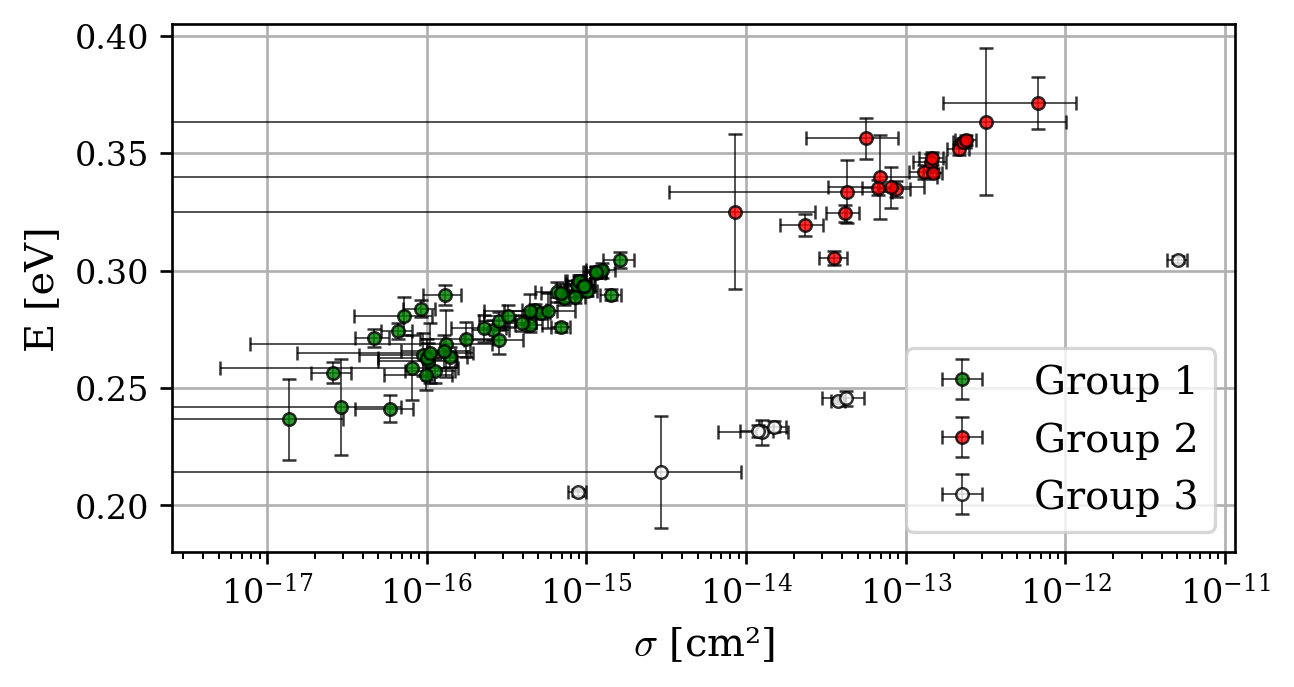

In [9]:
def gaussiana_2d(x, y, amplitud, mu_x, mu_y, sigma_x, sigma_y, rho):
    return amplitud * np.exp(
        -0.5
        * (
            (x - mu_x) ** 2 / sigma_x**2
            + (y - mu_y) ** 2 / sigma_y**2
            - 2 * rho * (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y)
        )
    )

e_vals = np.array([popt[0] * cte.Boltzmann / cte.eV for popt in popt_vals])
e_errs = np.array([perr[0] * cte.Boltzmann / cte.eV for perr in perr_vals])
sigma_vals = np.array([seccion_eficaz(popt[1]) for popt in popt_vals])
sigma_errs = np.array(
    [
        sigma / popt[1] * perr[1]
        for sigma, popt, perr in zip(sigma_vals, popt_vals, perr_vals)
    ]
)
plt.subplots(1, 1, figsize=(8/1.4, 4/1.4))
# filtro = (e_vals > 0.15)
# plt.hist(e_vals, bins=20, ec="k")
filtros_clusters = [
    (sigma_vals < 5e-15) & (e_vals > 0.225),
    (sigma_vals > 5e-15) & (e_vals > 0.300) & (sigma_vals < 1e-12),
]
filtros_clusters.append(~filtros_clusters[0] & ~filtros_clusters[1])
for filtro, color, tag in zip(
    filtros_clusters, ["g", "r", "w"], ["Group 1", "Group 2", "Group 3"]
):
    plt.errorbar(
        sigma_vals[filtro],
        e_vals[filtro],
        xerr=sigma_errs[filtro],
        yerr=e_errs[filtro],
        fmt=".",
        markersize=7.5,
        markeredgewidth=0.75,
        markeredgecolor="k",
        ecolor="k",
        capsize=2,
        elinewidth=0.5,
        markerfacecolor=color,
        alpha=0.8,
        label=tag,
        zorder=5,
    )
    # # Agrego una gaussiana asociada a los puntos del grupo
    # if tag != "Otros":
    #     vals = np.array([np.log(sigma_vals[filtro]), e_vals[filtro]]).T
    #     mu = np.mean(vals, axis=0)
    #     std = np.std(vals, axis=0)
    #     corr = np.corrcoef(vals.T)[0, 1]
    #     print(f"mu = {mu}")
    #     print(f"std = {std}")
    #     print(f"corr = {corr}")

    #     x_vals = np.linspace(np.log(1e-17), np.log(1e-11), 100)
    #     y_vals = np.linspace(0.2, 0.4, 100)
    #     X, Y = np.meshgrid(x_vals, y_vals)
    #     Z = gaussiana_2d(X, Y, 1, mu[0], mu[1], std[0], std[1], corr)
    #     cmap = "Greens" if color == "g" else "Reds"
    #     plt.contour(np.exp(X), Y, Z, levels=4, cmap=cmap, zorder=3, alpha=0.75)
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("$\sigma$ [cm²]")
plt.xscale("log")
plt.ylabel("E [eV]")
# plt.ylabel("Count")

plt.show()

In [21]:
traps_physical_params = np.array([e_vals, e_errs, sigma_vals, sigma_errs]).T
np.savetxt("skipper_image_analysis/TRAPS_estudio_fondo/traps_physical_params.csv", traps_physical_params, delimiter=",", header="E [eV], error E [eV], sigma [cm^2], error sigma [cm^2]")

In [51]:
def tau_e_bis(
    T: float,  # K
    sigma: float,  # cm²
    E: float,  # eV
) -> float:  # s
    h_planck = cte.h / cte.eV  # eV·s
    m_e = cte.electron_mass / cte.eV  # eV
    k_boltz = cte.Boltzmann / cte.eV  # eV/K
    m_cond = 0.41 * m_e  # eV
    m_dens = 0.94 * m_e  # eV
    v_th = np.sqrt(3*k_boltz*T/m_cond)  # m/s
    N_c = 2 * (2*np.pi*m_dens*k_boltz*T/(h_planck**2))**(3/2)  # m⁻³
    tau_e = np.exp(E / (k_boltz * T)) / ((sigma / 100**2) * v_th * N_c)  # s
    return tau_e


sigma_vals = np.geomspace(1e-24, 1e-6, 600)
e_vals = np.arange(0.12, 0.8, 0.001)
temp_vals = np.array(list(CARPETAS_POR_TEMP.keys()))
sigma_grid, e_grid, T_grid = np.meshgrid(sigma_vals, e_vals, temp_vals, indexing="xy")

tau_e_grid = tau_e_bis(T_grid, sigma_grid, e_grid)

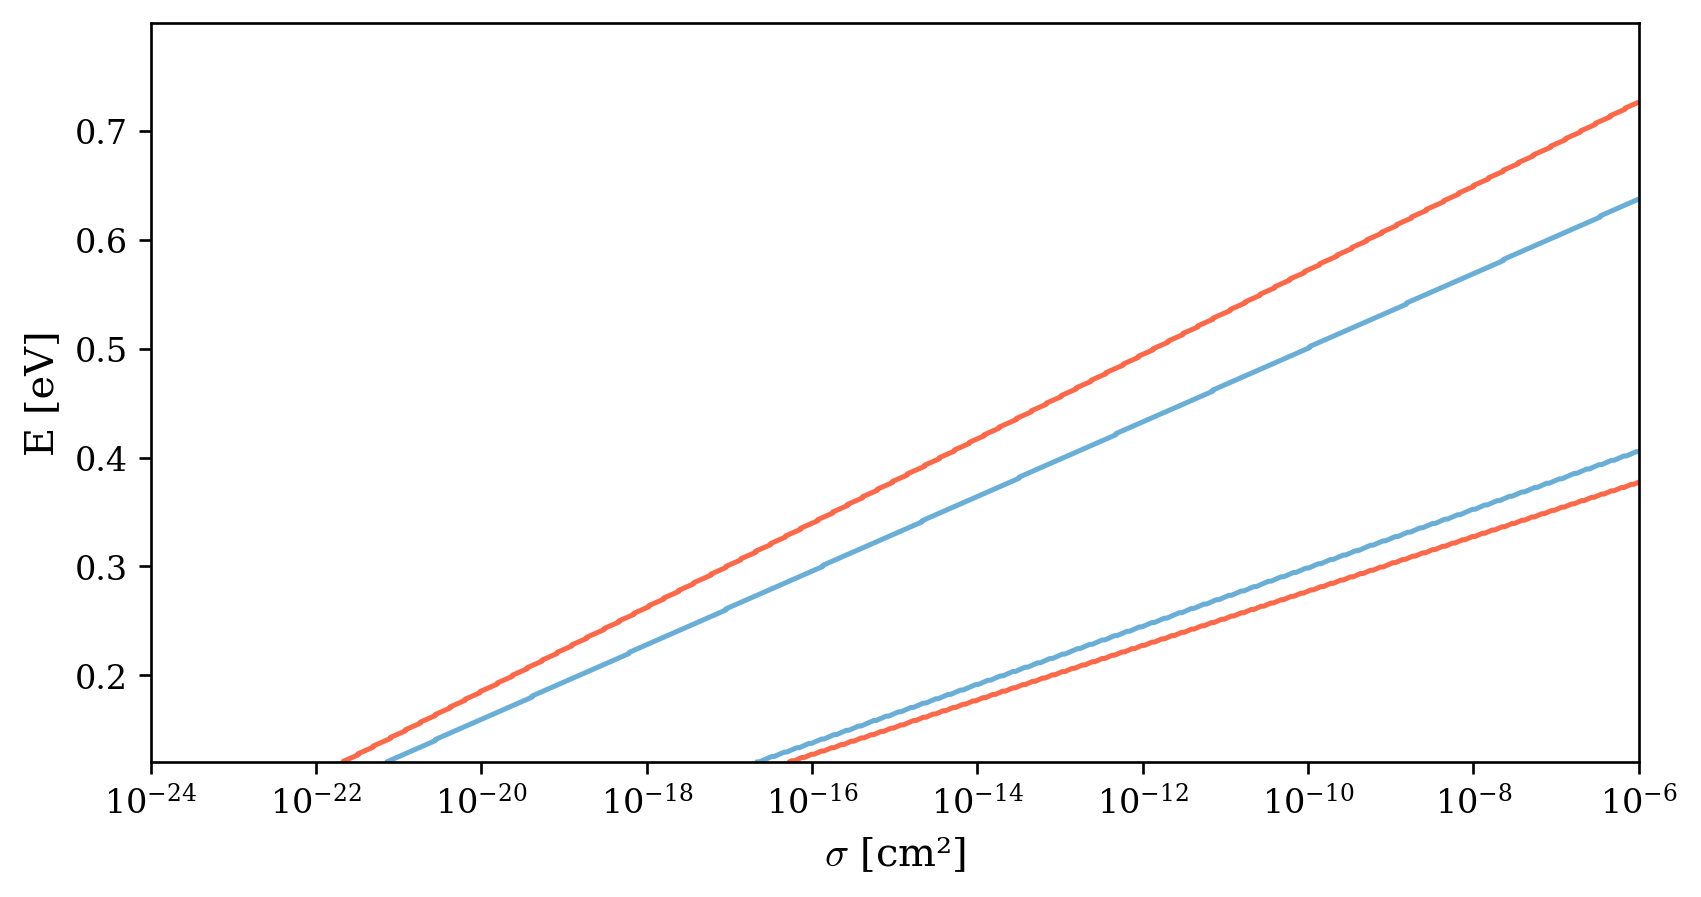

In [52]:
max_tau_observable = DTPH_VALS[-2] / CLOCKS_TO_SEC / 0.296  # s
min_tau_observable = DTPH_VALS[1] / CLOCKS_TO_SEC / 0.296  # s
son_observables = (np.max(tau_e_grid, axis=-1) > min_tau_observable) & (np.min(tau_e_grid, axis=-1) < max_tau_observable)
# True dónde hay al menos 4 temperaturas para las que es observable
hubieramos_considerado = np.sum(
    (tau_e_grid > min_tau_observable) & (tau_e_grid < max_tau_observable),
    axis=-1,
) >= 4

plt.subplots(1, 1, figsize=(8, 4))
plt.contour(
    sigma_vals, e_vals, hubieramos_considerado,
    cmap="Blues", levels=[0, 0.5, 1],
    
)
plt.contour(
    sigma_vals, e_vals, son_observables,
    cmap="Reds", levels=[0, 0.5, 1],
)
plt.xscale("log")
plt.xlabel("$\sigma$ [cm²]")
plt.ylabel("E [eV]")
plt.show()

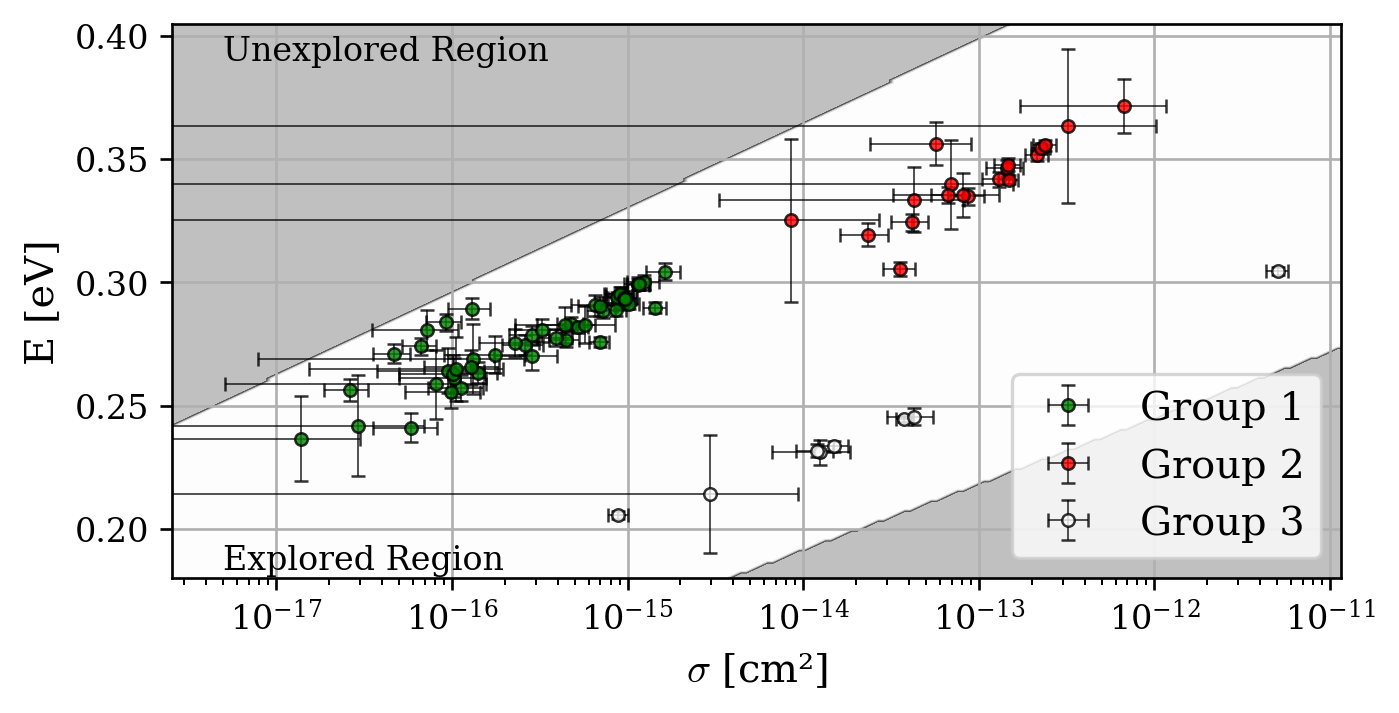

In [53]:
e_vals = np.array([popt[0] * cte.Boltzmann / cte.eV for popt in popt_vals])
e_errs = np.array([perr[0] * cte.Boltzmann / cte.eV for perr in perr_vals])
sigma_vals = np.array([seccion_eficaz(popt[1]) for popt in popt_vals])
sigma_errs = np.array(
    [
        sigma / popt[1] * perr[1]
        for sigma, popt, perr in zip(sigma_vals, popt_vals, perr_vals)
    ]
)
plt.subplots(1, 1, figsize=(8/1.4, 4/1.4), constrained_layout=True)
filtros_clusters = [
    (sigma_vals < 5e-15) & (e_vals > 0.225),
    (sigma_vals > 5e-15) & (e_vals > 0.300) & (sigma_vals < 1e-12),
]
filtros_clusters.append(~filtros_clusters[0] & ~filtros_clusters[1])
for filtro, color, tag in zip(
    filtros_clusters, ["g", "r", "w"], ["Group 1", "Group 2", "Group 3"]
):
    plt.errorbar(
        sigma_vals[filtro],
        e_vals[filtro],
        xerr=sigma_errs[filtro],
        yerr=e_errs[filtro],
        fmt=".",
        markersize=7.5,
        markeredgewidth=0.75,
        markeredgecolor="k",
        ecolor="k",
        capsize=2,
        elinewidth=0.5,
        markerfacecolor=color,
        alpha=0.8,
        label=tag,
        zorder=5,
    )

plt.grid()
plt.legend(loc="lower right")
plt.xlabel("$\sigma$ [cm²]")
plt.xscale("log")
plt.ylabel("E [eV]")
x_lims = plt.gca().get_xlim()
y_lims = plt.gca().get_ylim()

plt.contourf(
    sigma_grid[:, :, 0], e_grid[:, :, 0], son_observables & hubieramos_considerado,
    cmap="binary_r", levels=np.linspace(0, 1, 20), alpha=0.25,
)
plt.text(5e-18, 0.4, "Unexplored Region", va="top", ha="left", color="k")
plt.text(5e-18, y_lims[0]+0.001, "Explored Region", va="bottom", ha="left", color="k")
plt.xlim(x_lims)
plt.ylim(y_lims)
# plt.ylabel("Count")
plt.savefig("plots_paper/sec_ef_energia.pdf", dpi=600, pad_inches=5)

plt.show()